In [99]:
import numpy as np
from numpy.random import multivariate_normal as mvn #For later example
from advectionGP.models.mfmodels import MeshFreeAdjointAdvectionDiffusionModel as MFModel
from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.wind import WindSimple1d #Wind model
import matplotlib.pyplot as plt

In [104]:
tlocL = np.linspace(0.5,9,30)
xloc=np.linspace(0.5,9,30) # x locations
sensN = len(xloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X= np.zeros((obsN*sensN,3)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X[:,0] = np.asarray(np.meshgrid(tlocL,xloc)).reshape(2,sensN*obsN)[0] #lower time
X[:,2] = np.asarray(np.meshgrid(tlocL,xloc)).reshape(2,sensN*obsN)[1] # x location
X[:,1] = X[:,0]+0.01 # upper time

sensors = FixedSensorModel(X,0.01) # establish sensor model arguments are sensor locations and spatial averaging

In [105]:
k_0 = 0.0001 #Diffusion coefficient
noiseSD = 0.5 #Observation noise
#N_feat=3000 # number of features used to approximate ground truth GP
boundary = ([0,0],[10,10])# corners of the grid - in units of space
kForward = EQ(2, 2.0) # generate EQ kernel arguments are lengthscale and variance
res = [200,200] # grid size for time and x
windmodel=WindSimple1d(1)

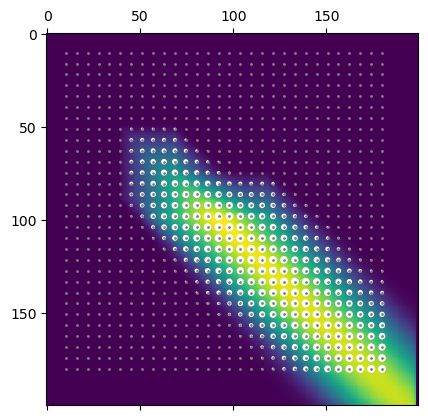

In [106]:
m = MFModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kForward,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=0)

delta, Ns = m.getGridStepSize() #useful numbers!
dt = delta[0]
#z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
#sourceGT=m.computeSourceFromPhi(z)# Compute ground truth source by approximating GP
sourceGT = np.zeros(m.resolution)
sourceGT[50:90,40:70] = 1.0 # Example constant source
sourceGT[75:100,50:120] = 1.0 # Example constant source

concGT = np.zeros(m.resolution)
for t in range(1,m.resolution[0]):
    concGT[t,3:-1] = concGT[t-1,2:-2]*0.5+concGT[t-1,3:-1]*0.18+concGT[t-1,1:-3]*0.18+concGT[t-1,4:]*0.07+concGT[t-1,:-4]*0.07
    concGT[t,:] += sourceGT[t,:]

def computeObservations(m,conc,noiseSD):
    #Taken from mesh_model.py    
    delta, _ = m.getGridStepSize()
    obs = np.zeros(len(m.sensormodel.obsLocs))
    for it,h in enumerate(m.sensormodel.getHs(m)):
        obs[it]=np.sum(h*conc)*np.prod(delta)
        obs[it]+=np.random.normal(0.0,noiseSD,1)      
    return obs

yTrain= computeObservations(m,concGT,0.01)        
plt.matshow(concGT)
plt.scatter(X[:,2]/delta[1],X[:,0]/delta[0],0.5*yTrain,color='white')
plt.scatter(X[:,2]/delta[1],X[:,0]/delta[0],1,color='grey')

In [109]:
lowres = [50,40]
N_feat = 1000
k = EQ(3, 10.0) # Initiate kernel for inverse problem
mMFInfer = MFModel(resolution=lowres,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #Initiate new model for inference
mMFInfer.computeModelRegressors(Nparticles=7) # Compute regressor matrix
meanZ, covZ = mMFInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix

Initialising particles...
Diffusing particles...
Computing SS...
Inverting SS...
Computing meanZ
Done


In [110]:
sourceInfer = mMFInfer.computeSourceFromPhiInterpolated(meanZ) # Generates estimated source using mean of the inferred distribution

cache miss, computing source from phi...


In [111]:
samps = mvn(meanZ,covZ,30)

In [112]:
res = np.array([mMFInfer.computeSourceFromPhi(samp) for samp in samps])

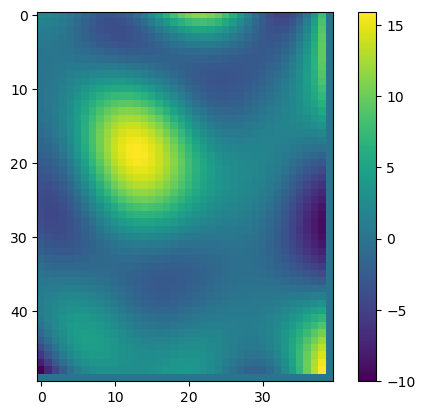

In [113]:
plt.imshow(sourceInfer)
plt.colorbar()

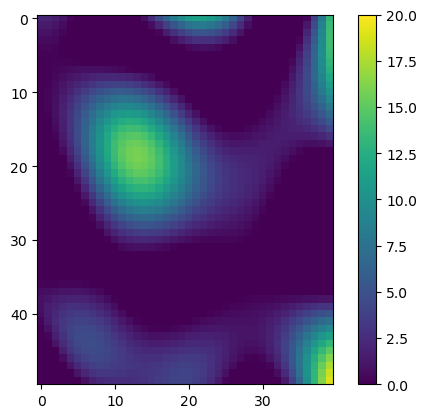

In [117]:
plt.imshow(np.mean(res,0))
plt.colorbar()
plt.clim([0,20])

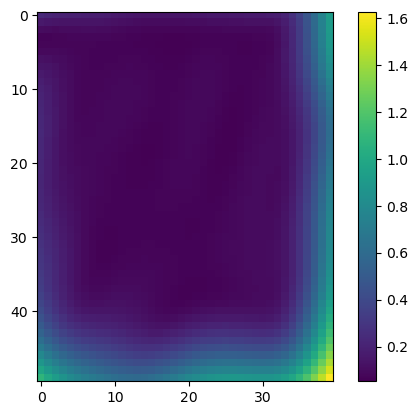

In [115]:
plt.imshow(np.std(res,0))
plt.colorbar()

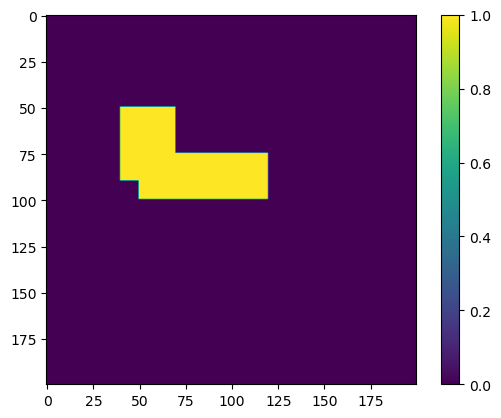

In [118]:
plt.imshow(sourceGT[:,:])
plt.colorbar()

In [121]:
meanS, covS = mMFInfer.computeSourceDistribution(meanZ,covZ)
#covS = np.std(res,0)
#meanS = np.mean(res,0)

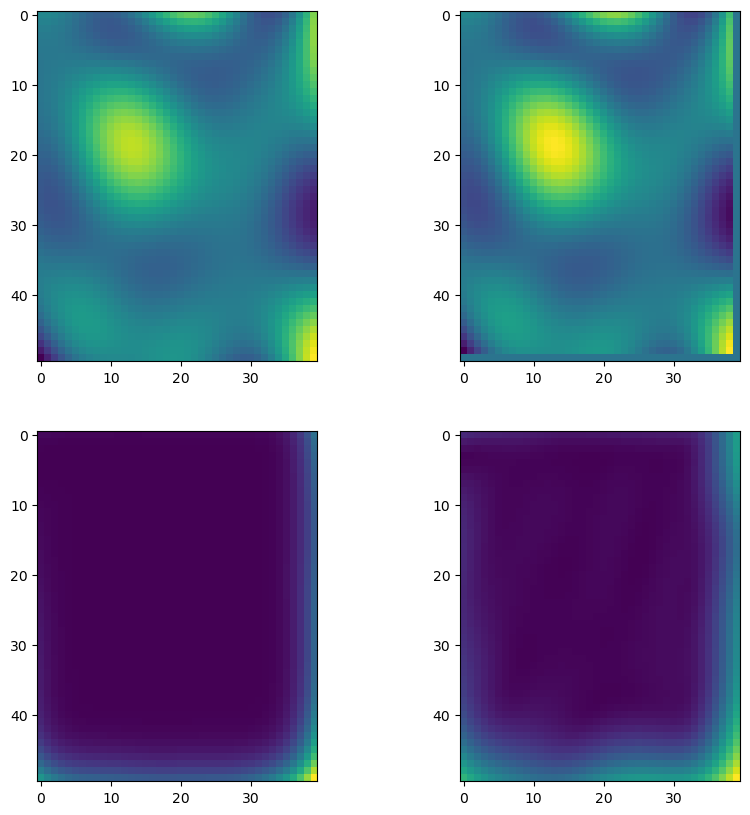

In [122]:
plt.figure(figsize=[10,10])
plt.subplot(2,2,1)
plt.imshow(meanS)
plt.subplot(2,2,2)
plt.imshow(sourceInfer)
plt.subplot(2,2,3)
plt.imshow(covS)
plt.subplot(2,2,4)
plt.imshow(np.std(res,0))

In [123]:
def computeSourceDistribution(self,meanZ,covZ,coords=None):
    """
    Computes the S distribution (at each grid point) using the previously inferred mean and covariance of z. Does not compute joint distribution due to required size of covariance matrix
    Arguments:
        meanZ: an Nfeat long vector inferred using computeZDistribution
        covZ: an Nfeat x Nfeat matrix inferred using computeZDistribution
    """
    #uses self.X and observations y.
    #dt,dx,dy,dx2,dy2,Nt,Nx,Ny = self.getGridStepSize()

    if coords is None:
        coords = self.coords

    #delta, Ns = self.getGridStepSize()
    Ns = coords.shape[1:]

    meanSource = self.computeSourceFromPhi(meanZ)
    varSource = np.zeros(Ns)#((Nt,Nx,Ny))
    
    #could run out of memory...
    phis = np.array(list(self.kernel.getPhi(coords)))
    #print(phis.T.shape, np.tensordot(covZ,phis,1).shape)
    varSource = np.tensordot(phis.T,np.tensordot(covZ,phis,1),1)
    #varSource = None
    #for i,phii in enumerate(phis):
    #    for j,phij in enumerate(phis):
    #        print(covZ.shape,phii.shape,phij.shape)
    #        varSource += covZ[i,j]*phii*phij
    return meanSource,varSource.transpose([1,0,2,3])
            
meanSource,varSource = computeSourceDistribution(mMFInfer, meanZ,covZ, mMFInfer.coords)

In [124]:
np.array([[varSource[i,j,i,j] for j in range(4)] for i in range(4)])

array([[0.04998454, 0.04387767, 0.03922472, 0.03573994],
       [0.0259691 , 0.02204917, 0.01923835, 0.01728667],
       [0.01234048, 0.01015103, 0.00871948, 0.00784773],
       [0.00603033, 0.00505914, 0.00451782, 0.00427646]])

In [125]:
covS[:4,:4]

array([[0.04998454, 0.04387767, 0.03922472, 0.03573994],
       [0.0259691 , 0.02204917, 0.01923835, 0.01728667],
       [0.01234048, 0.01015103, 0.00871948, 0.00784773],
       [0.00603033, 0.00505914, 0.00451782, 0.00427646]])

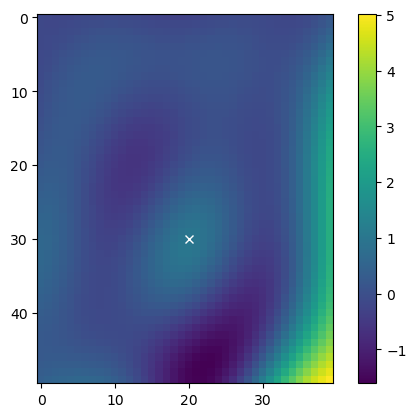

In [128]:
plt.imshow(varSource[30,20,:,:]/varSource[30,20,30,20])
plt.plot(20,30,'xw')
plt.colorbar()

In [129]:
mMFInfer.coords.shape[1:]

(50, 40)

In [130]:
mMFInfer.sensormodel.obsLocs

array([[0.5       , 0.51      , 0.5       ],
       [0.79310345, 0.80310345, 0.5       ],
       [1.0862069 , 1.0962069 , 0.5       ],
       ...,
       [8.4137931 , 8.4237931 , 9.        ],
       [8.70689655, 8.71689655, 9.        ],
       [9.        , 9.01      , 9.        ]])

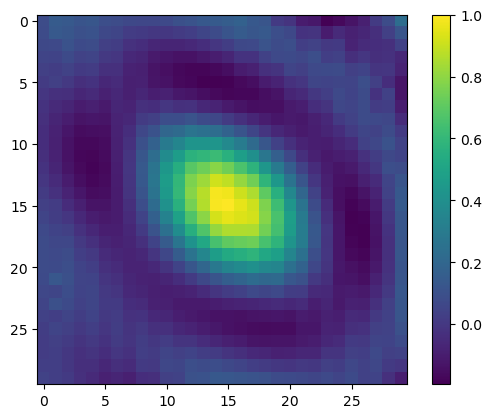

In [140]:
covObs = (mMFInfer.X.T @ covZ @ mMFInfer.X)
p = 30*15+15
plt.imshow(covObs[p,:].reshape(30,30)/covObs[p,p])
plt.colorbar()